[Implementation of NICE (Non-Linear Independent Components Estimation)](https://arxiv.org/pdf/1410.8516.pdf)

In [1]:
%load_ext autoreload
%autoreload 2

import os

import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Environment Path Constants you can change
DATASET_PATH = './datasets/'
CHECKPOINT_PATH ='./checkpoints/NICE/'
OUTPUT_PATH = './outputs/NICE/'
CHECKPOINT_FILE ='' # If you want to load a checkpoint.

# Data Loading Constants (Dependent on your hardware)
DATASET = ['CIFAR10', 'MNIST'][1]
BATCH_SIZE = 200
NUM_WORKERS = 10
PIN_MEMORY = True

# Training Constants
BATCH_PRINT = 50 # Every 50 batches print training progress.
EPOCH_CHECKPOINT = 10 # Every 10 epochs, save a checkpoint.
NUM_EPOCHS = 100
IS_TRAINING= True # Start training a model, unless you want to load a checkpoint instead.

# Set device to gpu by default if available.
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# For some reproducibility and determinism (Not gauranteed)
torch.manual_seed(0)
g = torch.Generator()
g.manual_seed(0)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


print(f'Device: {device}')
print(f'CPU Count: {os.cpu_count()}')
print(f'Number of DataLoading Workers: {NUM_WORKERS}')
print(f'Batch Size: {BATCH_SIZE}')
print(f'Dataset: {DATASET}')

Device: cuda:0
CPU Count: 20
Number of DataLoading Workers: 10
Batch Size: 200
Dataset: MNIST


### Dequantization
Using the same dequantization method from [RNADE: The real-valued neural autoregressive density-estimator](https://arxiv.org/pdf/1306.0186.pdf), section 4.2 as referenced by NICE.

Without dequantization maximizing the likelihood of our parameters relative to discrete data will result in an arbitrarily high value since the model will "cheat" as the paper describes. With discrete points the distribution would be "spiky" in the continuous space where the width of each of these points approaches 0. So, you can imagine that when we try to maximize the likelihood (in continuous space) the model will just give these points an arbitrary high value in $log(p(x;\theta))$ where $p(x;\theta)$ will have very low probability due to infinitesimal width (discrete) resulting in $log(p(x;\theta)) \rightarrow \infty$ while maintaining the constraint that $\int p(x;\theta) = 1$, hence "cheating".

In [2]:
class Dequantize(nn.Module):
    def __init__(self, device='cpu'):
        super(Dequantize, self).__init__()
        lo = torch.tensor([0.], device=device)
        hi = torch.tensor([1.], device=device)
        self.prior = torch.distributions.Uniform(lo,hi)
        
    def forward(self, x):
        return (x*255 + self.prior.sample(x.shape).squeeze()).divide(256.)

### Data Loading
Only using CIFAR-10 and MNIST dataset for this notebook. However, the paper also uses SVHN. Just flatten and dequantize the data. This also contains some other dataset specific functionalities.

In [3]:
# Select Dataset
from torch.utils.data import Dataset
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
from torchvision.utils import make_grid

def show(x, title=''):
    """ Display a grid from a batched pytorch tensor.
    """
    img = make_grid(x)
    npimg = img.numpy()
    fig = plt.figure()
    plt.title(title)
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    return fig

def select_dataset(dataset):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.flatten()),
    ])
    
    if dataset == 'CIFAR10':
        train_data = CIFAR10(DATASET_PATH, train=True, download=True, transform=transform)
        test_data = CIFAR10(DATASET_PATH, train=False, download=True, transform=transform)
        show_grid = lambda x, title='': show(x.reshape(-1,3,32,32),title)
    elif dataset == 'MNIST':
        train_data = MNIST(DATASET_PATH, train=True, download=True, transform=transform)
        test_data = MNIST(DATASET_PATH, train=False, download=True, transform=transform)
        show_grid = lambda x, title='': show(x.reshape(-1,1,28,28),title)
    else:
        assert False, f'{dataset} does not exist.'
        
    return train_data, test_data, show_grid

train_data, test_data, show_grid = select_dataset(DATASET)

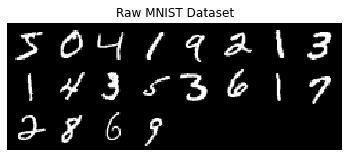

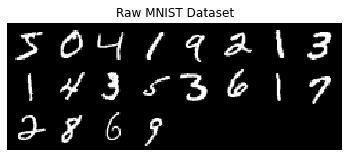

In [4]:
# Setup DataLoader
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=PIN_MEMORY, generator=g)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=PIN_MEMORY, generator=g)
x = next(iter(train_loader))[0][:20]
show_grid(x, 'Raw MNIST Dataset')

### Maintaining Invertibility
Since our model requires us to calculate the determinant of our jacobian (from Change Of Variables) it is absolutely vital that we seek to maintain this constraint while remaining computationally efficient. See: [What is a Jacobian?](https://www.youtube.com/watch?v=wCZ1VEmVjVo) and [Interpreting Determinant Jacobian](https://www.youtube.com/watch?v=p46QWyHQE6M)

One way to do this is use a simple coupling law on only half of the input. E.g: If we are using the MNIST dataset, then $x^{(i)}_{I_{1}} = [x^{(i)}_{0},x^{(i)}_{2},x^{(i)}_{4},...]$ and $x^{(i)}_{I_{2}} = [x^{(i)}_{1},x^{(i)}_{3},x^{(i)}_{5},...]$ If we do it in this way our jacobian becomes a lower triangular matrix. This would imply that our determinant would simply be the product of the diagonal of this matrix (Review linear algebra basics if you don't know why). The other half will simply be the identity function.

$f(x_{I_{1}}, x_{I_{2}}) = \begin{bmatrix} x_{I_{1}}\newline g(x_{I_{1}}, x_{I_{2}})\end{bmatrix}$

$\triangledown_{x} f = \begin{bmatrix} I & 0 \newline \dfrac{\partial g(x_{I_{1}}, x_{I_{2}})}{\partial x_{I_{1}}} & \dfrac{\partial g(x_{I_{1}}, x_{I_{2}})}{\partial x_{I_{2}}}\end{bmatrix}$

$|\triangledown_{x} f| = I \times \dfrac{\partial g(x_{I_{1}}, x_{I_{2}})}{\partial x_{I_{2}}} = \dfrac{\partial g(x_{I_{1}}, x_{I_{2}})}{\partial x_{I_{2}}}$

### Additive Coupling Layer
**Additive Coupling Law:** $g(a;b) = a + b$, where $g:\mathbb{R}^{D-d}\times m(\mathbb{R}^{d}) \rightarrow \mathbb{R}^{D-d}$

We'll use this additive law for each MLP layer where $x_{I_{1}}$ and $x_{I_{2}}$ is the input split in two. 

**Coupling Layer:** 

$z^{(i)}_{I_{1}} = x^{(i)}_{I_{1}}$

$z^{(i)}_{I_{2}} = g(x^{(i)}_{I_{1}}, x^{(i)}_{I_{2}}) = x^{(i)}_{I_{2}} + m(x^{(i)}_{I_{1}})$, where m is a deep neural network (MLP).

**Inverted Coupling Layer:** 

$x^{(i)}_{I_{1}} = z^{(i)}_{I_{1}}$

$x^{(i)}_{I_{2}} = g^{-1}(x^{(i)}_{I_{1}}, x^{(i)}_{I_{2}}) = g(x^{(i)}_{I_{1}}, x^{(i)}_{I_{2}}) - m(x^{(i)}_{I_{1}})$

**Jacobian Determinant of Coupling Layer:**

$|\triangledown_{x} f| = I \times \dfrac{\partial g(x_{I_{1}}, x_{I_{2}})}{\partial x_{I_{2}}} = \dfrac{\partial g(x_{I_{1}}, x_{I_{2}})}{\partial x_{I_{2}}} = 1$

When using the additive coupling law to transform half of our input, its partial derivative becomes 1. This would imply that our model is "volume preserving" In the sense that with each transformation, the change in volume from $x \rightarrow z$ remains the same.

**Note:**
Stacking these coupling layers in succession requires us to alternate the output of each layer, otherwise only half of the input will actually be processed through all the layers. Therefore, it's important to do this equally on each half. So expect an even number of coupling layers in the model.

In [5]:
# Define Model
import torch.nn.functional as F

def add_coupling(z, m, flip=False, inverse=False):
    n = z.shape[1]
    z = z.reshape(-1, n//2, 2) # Reshaping the tensor in this way results in odd and even indexed inputs in the last dimension.
    
    # Alternate the input
    if flip:
        z2, z1 = z[:,:,0], z[:,:,1]
    else:
        z1, z2 = z[:,:,0], z[:,:,1]
        
    # Invert the coupling law
    if not inverse:
        z2 = z2 + m(z1)
    else:
        z2 = z2 - m(z1)
    
    # Bring it back to its original shape
    if flip: 
        z = torch.stack((z2.unsqueeze(-1),z1.unsqueeze(-1)), dim=2).reshape(-1,n)
    else:
        z = torch.stack((z1.unsqueeze(-1),z2.unsqueeze(-1)), dim=2).reshape(-1,n)
        
    return z

class MLP(torch.nn.Module):
    """ NOTE: Paper uses ReLU with Linear Output Units
    """
    def __init__(self, in_dim, out_dim, hidden_dim, num_layers):
        super(MLP, self).__init__()
        model = []
        
        for l in range(num_layers):
            if l == 0:
                model.append(nn.Linear(in_dim, hidden_dim))
                model.append(nn.ReLU())
            elif l == num_layers-1:
                model.append(nn.Linear(hidden_dim, out_dim))
            else:
                model.append(nn.Linear(hidden_dim, hidden_dim))
                model.append(nn.ReLU())
                
        self.mlp = nn.Sequential(*model)
        
    def forward(self, x):
        return self.mlp(x)

In [6]:
# Test to make sure this is working correctly.
z = torch.arange(784, device=device, dtype=torch.float).reshape(1,-1)
m = MLP(392,392,1000,6).to(device)

z_new = add_coupling(z, m, flip=False)
z_new = add_coupling(z_new, m, flip=True)
z_new = add_coupling(z_new, m, flip=False)
z_new = add_coupling(z_new, m, flip=True)
z_recon = add_coupling(z_new, m, flip=True, inverse=True)
z_recon = add_coupling(z_recon, m, flip=False, inverse=True)
z_recon = add_coupling(z_recon, m, flip=True, inverse=True)
z_recon = add_coupling(z_recon, m, flip=False, inverse=True)

print('MSE', ((z - z_recon)**2).mean().cpu().item())

MSE 5.773667134667537e-12


### Scaling
As stated before, since our Jacobian Detetmminant is 1, it is volume preserving. We scale each dimension across the diagonal of the Jacobian by some factor in order to allow for more model variation.

**Note:** If some arbitrary scale approaches $-\infty$ or $\infty$, the dimensionality of this model will approach 1.

In [7]:
# For some reason this has to be a class. I don't know why pytorch requires this to be a class in order for
# the parameter to update. If you just add the parameter to the NICE model, it does not train correcty.

class Scaling(nn.Module):
    def __init__(self, dim):
        super(Scaling, self).__init__()
        self.scale = nn.Parameter(
            torch.zeros((1, dim)), requires_grad=True)

    def forward(self, x, reverse=False):
        log_det_J = torch.sum(self.scale)
        if reverse:
            x = x * torch.exp(-self.scale)
        else:
            x = x * torch.exp(self.scale)
        return x, log_det_J

### Model Definition (Section 5.1)

$h_{I_{1}}^{(1)} = x_{I_{1}}$

$h_{I_{2}}^{(1)} = x_{I_{2}} + m^{(1)}(x_{I_{1}})$

$h_{I_{2}}^{(2)} = h_{I_{2}}^{(1)}$

$h_{I_{2}}^{(2)} = h_{I_{1}}^{(1)} + m^{(2)}(x_{I_{2}})$

$h_{I_{2}}^{(3)} = h_{I_{2}}^{(2)}$

$h_{I_{2}}^{(3)} = h_{I_{2}}^{(2)} + m^{(3)}(x_{I_{1}})$

$h_{I_{2}}^{(4)} = h_{I_{2}}^{(3)}$

$h_{I_{1}}^{(4)} = h_{I_{1}}^{(3)} + m^{(4)}(x_{I_{2}})$

$h= exp(s)\odot h^{(4)}$

where $m$ is the coupling function and h's are the input/outputs.

In [8]:
# Define the main model
def logistic(sample_shape, prior):
    z = prior.sample(sample_shape).squeeze()
    return torch.log(z) - torch.log(1. - z)

def log_logistic(z):
    return -(F.softplus(z) + F.softplus(-z))
    #return -torch.log(1 + torch.exp(z)) - torch.log(1 + torch.exp(-z))

class NICE(torch.nn.Module):
    def __init__(self, num_coupling=4, num_dim=784, num_hidden_units=1000, num_hidden_layers=4, prior_fn=log_logistic, coupling_fn=add_coupling, device='cpu'):
        super(NICE, self).__init__()
        assert num_coupling % 2 == 0, 'We want an even number of swaps.'
        
        self.coupling_fn = add_coupling
        self.prior_fn = log_logistic
        self.mlps = nn.ModuleList([ MLP(num_dim // 2, num_dim // 2, num_hidden_units, num_hidden_layers+2).to(device) for i in range(num_coupling)])
        #self.scaling = nn.Parameter(torch.rand(1, num_dim), requires_grad=True).to(device) # Apparently this has to be not equal to 0, it can't be rand either, it has to be a module.
        self.scaling = Scaling(num_dim)
        self.dequantize = Dequantize(device)
        
    def forward(self, x):
        # Transform to P_x -> P_z
        z = self.dequantize(x)
        for i, m in enumerate(self.mlps):
            z = self.coupling_fn(z, m, flip=(i%2 != 0), inverse=False)
        
        #z = torch.exp(self.scaling) * z
        #logdet = self.scaling
        z, logdet = self.scaling(z)
        logprior = log_logistic(z)
        
        return logprior, logdet
    
    def sample(self, sample_shape=(64,784)):
        return self.inverse(logistic(sample_shape))

    def inverse(self, z):
        x = z
        x, _ = self.scaling(x, reverse=True)

        for i, m in reversed(list(enumerate(self.mlps))):
            x = self.coupling_fn(x, m, flip=(i%2 != 0 ), inverse=True)
        return x

### Log Likelihood

Recall the change of variable:

$p_{X}(x) = p_{H}(f(x))|det\dfrac{\partial f(x)}{\partial x}|$, where $p_{H}$ is our prior (Logistic Distribution), and $p_{X}$ is the distribution of our dataset.

In NICE, we assume that each component, $h_{d}$ is independent and so $p_{H}$ factorizes into $p_{H}(h) = \prod_{d}p_{H_{d}}(h_{d})$.

And so now we simply maximize the log likelihood using the change of variable likeso:

$log(p_{X}(x)) = \sum_{d=1}^{D}log(p_{H_{d}}(f_{d}(x))) + log(|det(\dfrac{\partial f(x)}{\partial x})|)$

This is now:

$log(p_{X}(x)) = \sum_{d=1}^{D}log(p_{H_{d}}(f_{d}(x))) + log(|S_{ii}|)$, where $S_{ii}$ are the learned scaling parameters used in conjunction with the unit determinant jocabian of the additive coupling layers.



In [9]:
# Loss Function.
def log_likelihood(logprior, logdet):
    return logprior.sum(dim=1) + logdet

### Hyper Parameters
![Section 5.1](./images/NICE_hyperparameters.JPG)

Section 5.1 in the paper.

**Note:** Not using ZCA in this notebook. If you want it, add it to to DataLoader preprocessing.

In [17]:
from torch import optim

# Model Configuration
if DATASET == 'MNIST':
    hyper_parameters = {
        'num_dim': 784,
        'num_hidden_units':1000,
        'device': device
    }
    
    model = NICE(**hyper_parameters).to(device)
    sample_shape = (64,784)
    img_shape = (1,28,28)
elif DATASET == 'CIFAR10':
    hyper_parameters = {
        'num_dim': 3072,
        'num_hidden_units': 2000,
        'device': device    
    }
    
    model = NICE(**hyper_parameters).to(device)
    sample_shape = (64,3072)
    img_shape = (3,32,32)

optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=1e-4)

### Load Checkpoint
If available...

In [18]:
if CHECKPOINT_FILE != '':
    ckpt = CHECKPOINT_FILE
    model.load_state_dict(torch.load(ckpt)['model_state_dict'])
    optimizer.load_state_dict(torch.load(ckpt['optimizer_state_dict']))

### Training

Epochs: [0/100]	Batches: [1/300]	Samples: [200/60000]	Running Loss: 1107.483154296875
Running Batch Time: 0.4892148971557617
Epochs: [0/100]	Batches: [51/300]	Samples: [10200/60000]	Running Loss: 1082.342005112592
Running Batch Time: 0.01897442574594535
Epochs: [0/100]	Batches: [101/300]	Samples: [20200/60000]	Running Loss: 1061.5763688795637
Running Batch Time: 0.014262451983914516
Epochs: [0/100]	Batches: [151/300]	Samples: [30200/60000]	Running Loss: 1041.0666936407026
Running Batch Time: 0.012616073848395947
Epochs: [0/100]	Batches: [201/300]	Samples: [40200/60000]	Running Loss: 1020.7244086573966
Running Batch Time: 0.01178173639287996
Epochs: [0/100]	Batches: [251/300]	Samples: [50200/60000]	Running Loss: 1000.6019221454028
Running Batch Time: 0.01126982396342365
Saving ./checkpoints/NICE/NICE-MNIST-2021-09-21_21:47:30-0.pt.
Saving ./outputs/NICE/NICE-MNIST-2021-09-21_21:47:30-0-864.3529663085938.jpg


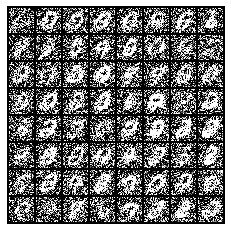

Training Likelihood: -980.9945526123047	Test Likelihood: -866.0029907226562
Epochs: [1/100]	Batches: [1/300]	Samples: [200/60000]	Running Loss: 864.957763671875
Running Batch Time: 1.4739625453948975
Epochs: [1/100]	Batches: [51/300]	Samples: [10200/60000]	Running Loss: 842.6867316750919
Running Batch Time: 0.03755589092479033
Epochs: [1/100]	Batches: [101/300]	Samples: [20200/60000]	Running Loss: 822.7063356909422
Running Batch Time: 0.02310091198080837
Epochs: [1/100]	Batches: [151/300]	Samples: [30200/60000]	Running Loss: 803.0099341790408
Running Batch Time: 0.01820389324466124
Epochs: [1/100]	Batches: [201/300]	Samples: [40200/60000]	Running Loss: 783.4874039835005
Running Batch Time: 0.015794542891469168
Epochs: [1/100]	Batches: [251/300]	Samples: [50200/60000]	Running Loss: 764.0614808831082
Running Batch Time: 0.014338740314620424
Training Likelihood: -745.0802803548177	Test Likelihood: -629.3424682617188
Epochs: [2/100]	Batches: [1/300]	Samples: [200/60000]	Running Loss: 628.6

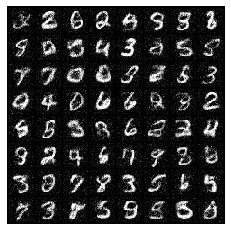

Training Likelihood: 932.3391035970052	Test Likelihood: 968.1051025390625
Epochs: [11/100]	Batches: [1/300]	Samples: [200/60000]	Running Loss: -999.5309448242188
Running Batch Time: 1.4765472412109375
Epochs: [11/100]	Batches: [51/300]	Samples: [10200/60000]	Running Loss: -1005.471409217984
Running Batch Time: 0.038317297019210515
Epochs: [11/100]	Batches: [101/300]	Samples: [20200/60000]	Running Loss: -1014.271675336479
Running Batch Time: 0.023483720156225827
Epochs: [11/100]	Batches: [151/300]	Samples: [30200/60000]	Running Loss: -1022.2410197479046
Running Batch Time: 0.018478477238029832
Epochs: [11/100]	Batches: [201/300]	Samples: [40200/60000]	Running Loss: -1031.6526531769862
Running Batch Time: 0.015976278343010897
Epochs: [11/100]	Batches: [251/300]	Samples: [50200/60000]	Running Loss: -1041.689275855562
Running Batch Time: 0.014497643922904573
Training Likelihood: 1051.6710626220704	Test Likelihood: 1078.39453125
Epochs: [12/100]	Batches: [1/300]	Samples: [200/60000]	Running

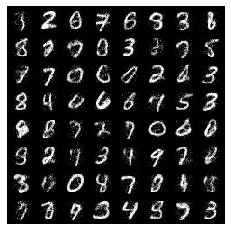

Training Likelihood: 1781.7893672688801	Test Likelihood: 1735.5906982421875
Epochs: [21/100]	Batches: [1/300]	Samples: [200/60000]	Running Loss: -1807.80517578125
Running Batch Time: 1.4640698432922363
Epochs: [21/100]	Batches: [51/300]	Samples: [10200/60000]	Running Loss: -1803.9550757314644
Running Batch Time: 0.03679096932504691
Epochs: [21/100]	Batches: [101/300]	Samples: [20200/60000]	Running Loss: -1806.1268117168163
Running Batch Time: 0.02240355416099624
Epochs: [21/100]	Batches: [151/300]	Samples: [30200/60000]	Running Loss: -1809.2896106037872
Running Batch Time: 0.01756179253786605
Epochs: [21/100]	Batches: [201/300]	Samples: [40200/60000]	Running Loss: -1814.6165115584188
Running Batch Time: 0.015127336207906999
Epochs: [21/100]	Batches: [251/300]	Samples: [50200/60000]	Running Loss: -1818.6736710385023
Running Batch Time: 0.01365675204303635
Training Likelihood: 1823.9515209960937	Test Likelihood: 1762.15478515625
Epochs: [22/100]	Batches: [1/300]	Samples: [200/60000]	Runn

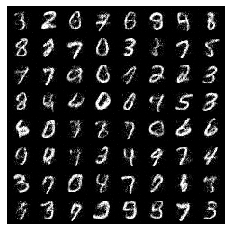

Training Likelihood: 1966.7326318359376	Test Likelihood: 1874.2723388671875
Epochs: [31/100]	Batches: [1/300]	Samples: [200/60000]	Running Loss: -1974.841064453125
Running Batch Time: 1.494112253189087
Epochs: [31/100]	Batches: [51/300]	Samples: [10200/60000]	Running Loss: -1975.4708778530944
Running Batch Time: 0.038339638242534564
Epochs: [31/100]	Batches: [101/300]	Samples: [20200/60000]	Running Loss: -1969.7157477954827
Running Batch Time: 0.02352880015231595
Epochs: [31/100]	Batches: [151/300]	Samples: [30200/60000]	Running Loss: -1967.9039468323158
Running Batch Time: 0.018531507214173577
Epochs: [31/100]	Batches: [201/300]	Samples: [40200/60000]	Running Loss: -1970.5491846188977
Running Batch Time: 0.015983010999005825
Epochs: [31/100]	Batches: [251/300]	Samples: [50200/60000]	Running Loss: -1970.964229994086
Running Batch Time: 0.014367402787227555
Training Likelihood: 1973.7917207845053	Test Likelihood: 1876.9208984375
Epochs: [32/100]	Batches: [1/300]	Samples: [200/60000]	Run

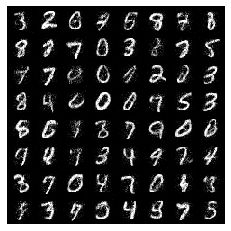

Training Likelihood: 2006.0826493326822	Test Likelihood: 1894.032958984375
Epochs: [41/100]	Batches: [1/300]	Samples: [200/60000]	Running Loss: -2015.22900390625
Running Batch Time: 1.4505462646484375
Epochs: [41/100]	Batches: [51/300]	Samples: [10200/60000]	Running Loss: -2013.008602366728
Running Batch Time: 0.037566699233709595
Epochs: [41/100]	Batches: [101/300]	Samples: [20200/60000]	Running Loss: -2003.9693107982673
Running Batch Time: 0.023225958984677154
Epochs: [41/100]	Batches: [151/300]	Samples: [30200/60000]	Running Loss: -2002.9607766258796
Running Batch Time: 0.01837280886062723
Epochs: [41/100]	Batches: [201/300]	Samples: [40200/60000]	Running Loss: -2006.320167959033
Running Batch Time: 0.01592946408399895
Epochs: [41/100]	Batches: [251/300]	Samples: [50200/60000]	Running Loss: -2006.1540853188808
Running Batch Time: 0.014463270802896812
Training Likelihood: 2009.3609891764322	Test Likelihood: 1893.2545166015625
Epochs: [42/100]	Batches: [1/300]	Samples: [200/60000]	Run

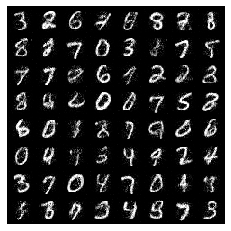

Training Likelihood: 2026.7538802083334	Test Likelihood: 1886.5054931640625
Epochs: [51/100]	Batches: [1/300]	Samples: [200/60000]	Running Loss: -2026.2188720703125
Running Batch Time: 1.468106985092163
Epochs: [51/100]	Batches: [51/300]	Samples: [10200/60000]	Running Loss: -2028.990181717218
Running Batch Time: 0.037468395981134155
Epochs: [51/100]	Batches: [101/300]	Samples: [20200/60000]	Running Loss: -2024.5701348333075
Running Batch Time: 0.0230560302734375
Epochs: [51/100]	Batches: [151/300]	Samples: [30200/60000]	Running Loss: -2024.0259565138658
Running Batch Time: 0.018168174667863655
Epochs: [51/100]	Batches: [201/300]	Samples: [40200/60000]	Running Loss: -2026.6266318553717
Running Batch Time: 0.015588896784616347
Epochs: [51/100]	Batches: [251/300]	Samples: [50200/60000]	Running Loss: -2025.47495272815
Running Batch Time: 0.014083561194370467
Training Likelihood: 2028.3741918945314	Test Likelihood: 1903.02734375
Epochs: [52/100]	Batches: [1/300]	Samples: [200/60000]	Running

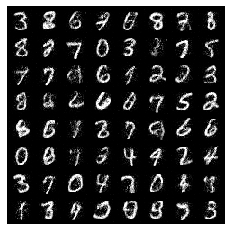

Training Likelihood: 2040.3980029296874	Test Likelihood: 1897.0313720703125
Epochs: [61/100]	Batches: [1/300]	Samples: [200/60000]	Running Loss: -2053.680419921875
Running Batch Time: 1.4873042106628418
Epochs: [61/100]	Batches: [51/300]	Samples: [10200/60000]	Running Loss: -2050.7981866574755
Running Batch Time: 0.03800149524913115
Epochs: [61/100]	Batches: [101/300]	Samples: [20200/60000]	Running Loss: -2043.4163165706218
Running Batch Time: 0.023229478609443893
Epochs: [61/100]	Batches: [151/300]	Samples: [30200/60000]	Running Loss: -2042.4296543550806
Running Batch Time: 0.01815125484340238
Epochs: [61/100]	Batches: [201/300]	Samples: [40200/60000]	Running Loss: -2044.3714544951026
Running Batch Time: 0.015592229900075428
Epochs: [61/100]	Batches: [251/300]	Samples: [50200/60000]	Running Loss: -2042.6298497416583
Running Batch Time: 0.01405395834569437
Training Likelihood: 2044.116055501302	Test Likelihood: 1888.5899658203125
Epochs: [62/100]	Batches: [1/300]	Samples: [200/60000]	R

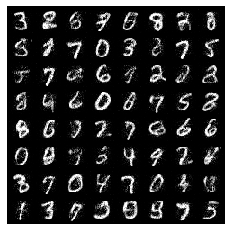

Training Likelihood: 2052.2567232259116	Test Likelihood: 1891.4713134765625
Epochs: [71/100]	Batches: [1/300]	Samples: [200/60000]	Running Loss: -2049.819091796875
Running Batch Time: 1.4796369075775146
Epochs: [71/100]	Batches: [51/300]	Samples: [10200/60000]	Running Loss: -2054.481055166207
Running Batch Time: 0.037946649626189585
Epochs: [71/100]	Batches: [101/300]	Samples: [20200/60000]	Running Loss: -2048.7914700649753
Running Batch Time: 0.023346789992681825
Epochs: [71/100]	Batches: [151/300]	Samples: [30200/60000]	Running Loss: -2049.8639643587026
Running Batch Time: 0.018342329176845928
Epochs: [71/100]	Batches: [201/300]	Samples: [40200/60000]	Running Loss: -2052.587685352534
Running Batch Time: 0.015688766887531944
Epochs: [71/100]	Batches: [251/300]	Samples: [50200/60000]	Running Loss: -2050.6973361437063
Running Batch Time: 0.014178115533167623
Training Likelihood: 2052.8982283528644	Test Likelihood: 1892.6243896484375
Epochs: [72/100]	Batches: [1/300]	Samples: [200/60000]

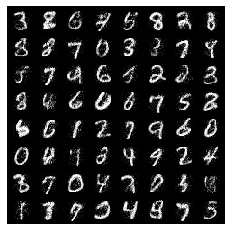

Training Likelihood: 2061.844748535156	Test Likelihood: 1887.0166015625
Epochs: [81/100]	Batches: [1/300]	Samples: [200/60000]	Running Loss: -2060.749267578125
Running Batch Time: 1.4821014404296875
Epochs: [81/100]	Batches: [51/300]	Samples: [10200/60000]	Running Loss: -2065.2972292432596
Running Batch Time: 0.03771218131570255
Epochs: [81/100]	Batches: [101/300]	Samples: [20200/60000]	Running Loss: -2057.8704302192914
Running Batch Time: 0.023052937913649152
Epochs: [81/100]	Batches: [151/300]	Samples: [30200/60000]	Running Loss: -2056.7731125181085
Running Batch Time: 0.018103997438948676
Epochs: [81/100]	Batches: [201/300]	Samples: [40200/60000]	Running Loss: -2058.9620652839317
Running Batch Time: 0.015629318816151785
Epochs: [81/100]	Batches: [251/300]	Samples: [50200/60000]	Running Loss: -2057.6236474998445
Running Batch Time: 0.014060673960651535
Training Likelihood: 2060.417578531901	Test Likelihood: 1898.8499755859375
Epochs: [82/100]	Batches: [1/300]	Samples: [200/60000]	Run

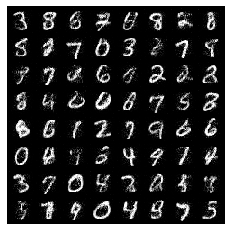

Training Likelihood: 2069.3231783040364	Test Likelihood: 1901.1669921875
Epochs: [91/100]	Batches: [1/300]	Samples: [200/60000]	Running Loss: -2079.186767578125
Running Batch Time: 1.4652676582336426
Epochs: [91/100]	Batches: [51/300]	Samples: [10200/60000]	Running Loss: -2073.7168734681372
Running Batch Time: 0.03738230349970799
Epochs: [91/100]	Batches: [101/300]	Samples: [20200/60000]	Running Loss: -2067.7371016398515
Running Batch Time: 0.02295828573774583
Epochs: [91/100]	Batches: [151/300]	Samples: [30200/60000]	Running Loss: -2066.9057075551013
Running Batch Time: 0.018087279717653792
Epochs: [91/100]	Batches: [201/300]	Samples: [40200/60000]	Running Loss: -2069.410012923663
Running Batch Time: 0.015643539713389838
Epochs: [91/100]	Batches: [251/300]	Samples: [50200/60000]	Running Loss: -2067.146753805092
Running Batch Time: 0.014166099616730831
Training Likelihood: 2069.1659375	Test Likelihood: 1894.2379150390625
Epochs: [92/100]	Batches: [1/300]	Samples: [200/60000]	Running Lo

In [19]:
from torchvision.utils import save_image
from datetime import datetime
from meters import LossMeter, HWMeter

# Generate a fixed point in logistic space to invert across training. Allows us to see progress.
lo = torch.tensor([0.], device=device)
hi = torch.tensor([1.], device=device)
fixed_sample = logistic(sample_shape, torch.distributions.Uniform(lo,hi))

# Record the inverse during training for visualization purposes
inverse_records = []
batch_rate = 2
max_iters = 300
rec_iter = 0
# Local training variables
train_lls = []
test_lls = []
epoch = 0
loss_meter = LossMeter(NUM_EPOCHS, len(train_loader), BATCH_SIZE, len(train_loader.dataset))
hw_meter = HWMeter(device)
while epoch < NUM_EPOCHS and IS_TRAINING:
        
        # Train Loop
        model.train()
        for i, (x,y) in enumerate(train_loader):
            optimizer.zero_grad()

            x = x.to(device)
            logprior, logdet = model(x)
            nll = -log_likelihood(logprior, logdet).mean()
            nll.backward()
            
            optimizer.step() 
            loss_meter.step(nll.item(), i, epoch)
            hw_meter.step(i)
            
            # Print some information
            if i % BATCH_PRINT == 0:
                loss_meter.print()
                hw_meter.print()
                
                # Record Inverse
                if rec_iter < max_iters:
                    with torch.no_grad():
                        sample = model.inverse(fixed_sample)
                        inverse_records.append((sample.detach(), epoch, i, -loss_meter.running_loss / (i+1)))
                    rec_iter += 1
        train_ll = -loss_meter.running_loss / len(train_loader)
        
        # Test Loop
        model.eval()
        with torch.no_grad():
            test_ll = 0.
            for i, (x,y) in enumerate(test_loader):
                x = x.to(device)
                logprior, logdet = model(x)
                ll = log_likelihood(logprior, logdet).sum()
                test_ll += ll
        test_ll /= len(test_loader.dataset)
        
        # Save Likelihoods
        train_lls.append(train_ll)
        test_lls.append(test_ll.item())

        # Store a Checkpoint
        if epoch % EPOCH_CHECKPOINT == 0:
            time = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
            ckptpath = f'{CHECKPOINT_PATH}NICE-{DATASET}-{time}-{epoch}.pt'
            torch.save({
                        'epoch': epoch,
                        'dataset': DATASET,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'train_ll': train_ll,
                        'test_ll': test_ll.item(),
                        **hyper_parameters
                        }, ckptpath)
            print(f'Saving {ckptpath}.')

            # Save a sample
            outpath = f'{OUTPUT_PATH}NICE-{DATASET}-{time}-{epoch}-{nll}.jpg'
            model.eval()
            with torch.no_grad():
                samples = model.inverse(fixed_sample)
            print(f'Saving {outpath}')
            grid = make_grid(samples.reshape(((-1,)+img_shape)).detach().cpu().clamp(0, 1))
            show(grid)
            plt.show()
            
        epoch += 1
        loss_meter.reset()
        hw_meter.reset()
        
        print(f'Training Likelihood: {train_ll}\tTest Likelihood: {test_ll}')


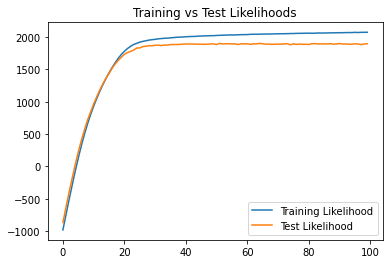

In [20]:
import imageio
import io

if IS_TRAINING:
    plt.figure()
    plt.title('Training vs Test Likelihoods')
    plt.plot(train_lls, label='Training Likelihood')
    plt.plot(test_lls, label='Test Likelihood')
    plt.legend()
    
    # Save Gif
    images = []
    for inv, epoch, batch, ll in inverse_records:
        grid = np.moveaxis(make_grid(inv.reshape(((-1,)+img_shape)).cpu()).clamp(0,1).numpy(),0,-1)
        fig = plt.figure(frameon=False)
        c,h,w = grid.shape
        fig.set_size_inches(3,3)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)

        plt.imshow(grid)
        
        io_buf = io.BytesIO()
        fig.savefig(io_buf, format='raw',)
        w, h = fig.canvas.get_width_height()
        io_buf.seek(0)
        img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),newshape=(h,w, -1))
        io_buf.close()
        plt.close()
        images.append(img_arr)
imageio.mimsave(f'NICE-{DATASET}.gif', images, duration = .05)


### Samples
Some random samples in logistic space inverted to data space.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


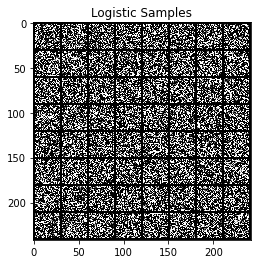

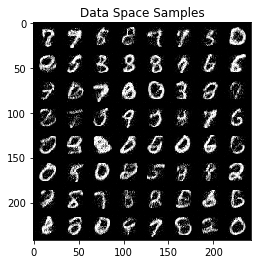

In [53]:
samples = logistic(sample_shape)
grid = make_grid(samples.reshape(((-1,)+img_shape)).detach().cpu())
plt.title('Logistic Samples')
show(grid)

plt.figure()
samples = model.inverse(samples)
grid = make_grid(samples.reshape(((-1,)+img_shape)).detach().cpu())
plt.title('Data Space Samples')
show(grid)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
for ax in axs:
    

### Manifold Visualization